In [1]:
import pandas as pd
import io
import json
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from joblib import dump

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def draw_hist_boxplot(df,features_names):
  sns.boxplot(x=features_names, data = df)
  sns.stripplot(x=features_names, data = df, color = '#474646')


def replace_outliers_with_median(df, feature_name):
              Q1 = df[feature_name].quantile(0.25)
              median = df[feature_name].quantile(0.5)
              Q3 = df[feature_name].quantile(0.75)
              IQR = Q3 - Q1
              lower_whisker = Q1 - 1.5 * IQR
              upper_whisker = Q3 + 1.5 * IQR
              df[feature_name] = np.where((df[feature_name] < lower_whisker) |
                                          (df[feature_name] > upper_whisker),
                                          median,
                                          df[feature_name])
            
def columns_without_values(data):
    columns = data.isnull().sum()
    print(columns[columns > 0])

In [4]:
df_numbers = pd.read_json('/content/drive/MyDrive/result.json')

In [5]:
df_numbers.drop(df_numbers[df_numbers.year < 2010].index, inplace = True)

In [6]:
df_numbers.drop(df_numbers[df_numbers.year > 2020].index, inplace = True)

In [7]:
df_numbers = df_numbers.drop(['fuelType','make','transmissionType','model','province','id','brand','brand_id','model_id','color','title','seller_type','fuel_types','bodyType','provinceId'], axis = 1)

In [8]:
df_numbers

,fuelTypeId,km,makeId,modelId,price,transmissionTypeId,year,cubicCapacity,doors,hp
0,2,41080,46,322,10990,2,2015,1329,5,99
1,1,78576,48,285,17450,2,2016,1969,5,120
2,1,99999,7,70,20999,1,2015,1995,5,184
3,4,79000,15,39,19990,1,2016,1999,4,187
4,1,105000,28,8,31900,1,2016,2143,4,170
...,...,...,...,...,...,...,...,...,...,...
3242,1,182000,34,503,26500,1,2010,2967,5,240
3243,1,99000,34,1097,49990,1,2017,2967,5,258
3244,2,59900,34,1097,50900,1,2014,2997,5,340
3245,1,99999,34,1097,51900,1,2016,2967,5,258


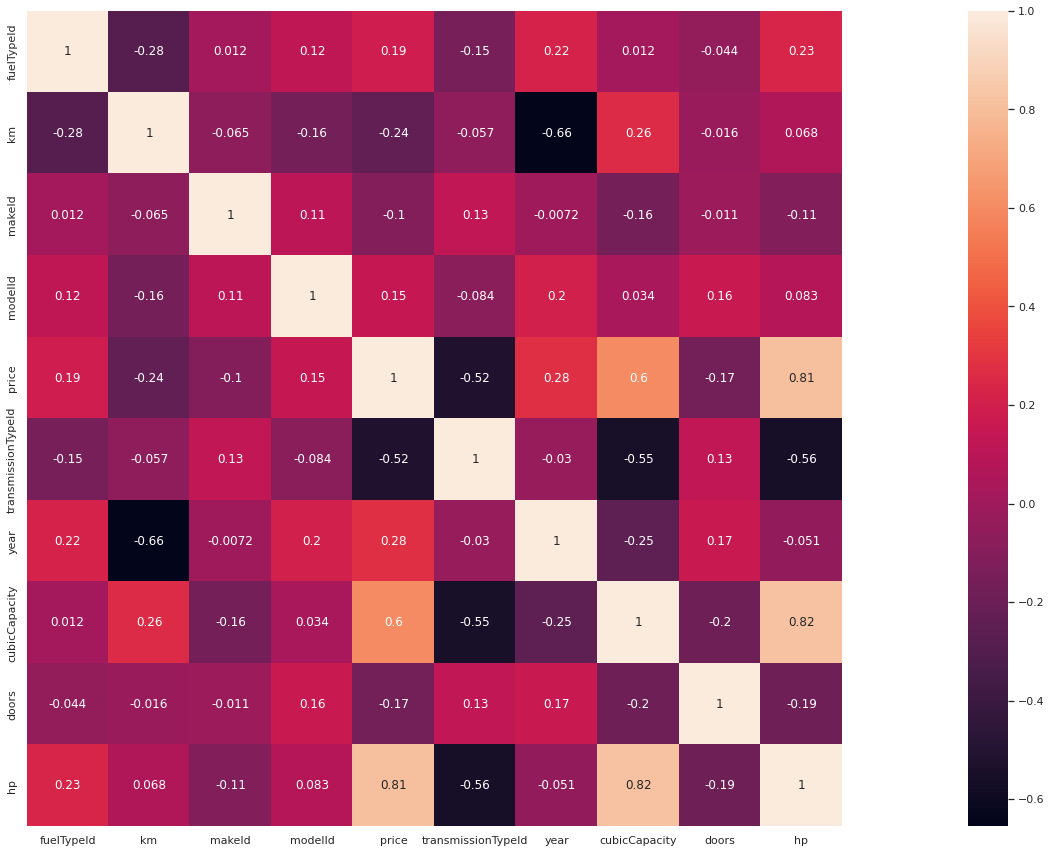

In [9]:
sns.set(rc = {'figure.figsize':(45,15)})
sns.heatmap(df_numbers.corr(), square=True, annot=True)

In [10]:
target = 'price'
all_features = ['km','year','cubicCapacity','doors','hp']

In [21]:
X_train_full, X_test = train_test_split(df_numbers[all_features + [target]], random_state=1)
X_train, X_val = train_test_split(X_train_full, random_state=1)
y_train = X_train[target].values
y_val = X_val[target].values
y_test = X_test[target].values
X_train.drop([target], axis=1, inplace=True)
X_val.drop([target], axis=1, inplace=True)
X_test.drop([target], axis=1, inplace=True)

In [22]:
from sklearn.feature_extraction import DictVectorizer
train_dict = X_train[all_features].to_dict(orient='records')
dict(sorted(train_dict[0].items()))
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

In [30]:
from sklearn.linear_model import LinearRegression
l_estimators = [2,4,8,16,32,64,128,256]
total_mae = []
for estimator in l_estimators:
  model = RandomForestRegressor(n_estimators=estimator, criterion='absolute_error', random_state=0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  total_mae.append(mean_absolute_error(y_test,y_pred))

best_est = l_estimators[np.argmax(total_mae)]
best_score = min(total_mae)
print("Min value (estimator : %i, MAE: %6.2f" % (best_est, best_score))



Min value (estimator : 2, MAE: 3379.48


In [38]:
model = RandomForestRegressor(n_estimators = 4, criterion='absolute_error', random_state=0)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
score = mean_absolute_error(y_test,y_predict)
sc = model.score(X_train, y_train)
sc

0.9584848489170076

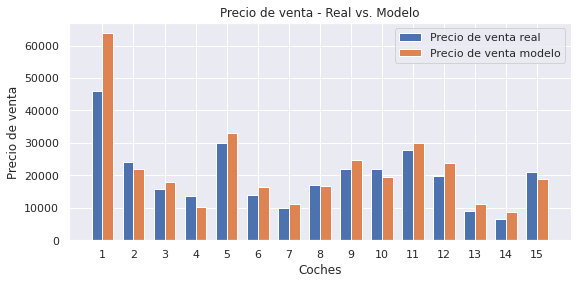

In [39]:
ind = np.arange(15)
width = 0.35
plt.figure(figsize=(9,4))
plt.bar(ind, y_test[100:115], width, label='Precio de venta real')
plt.bar(ind+width, y_predict[100:115], width, label='Precio de venta modelo')
plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')
plt.xlabel('Coches')
plt.ylabel('Precio de venta')
plt.title('Precio de venta - Real vs. Modelo')

plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


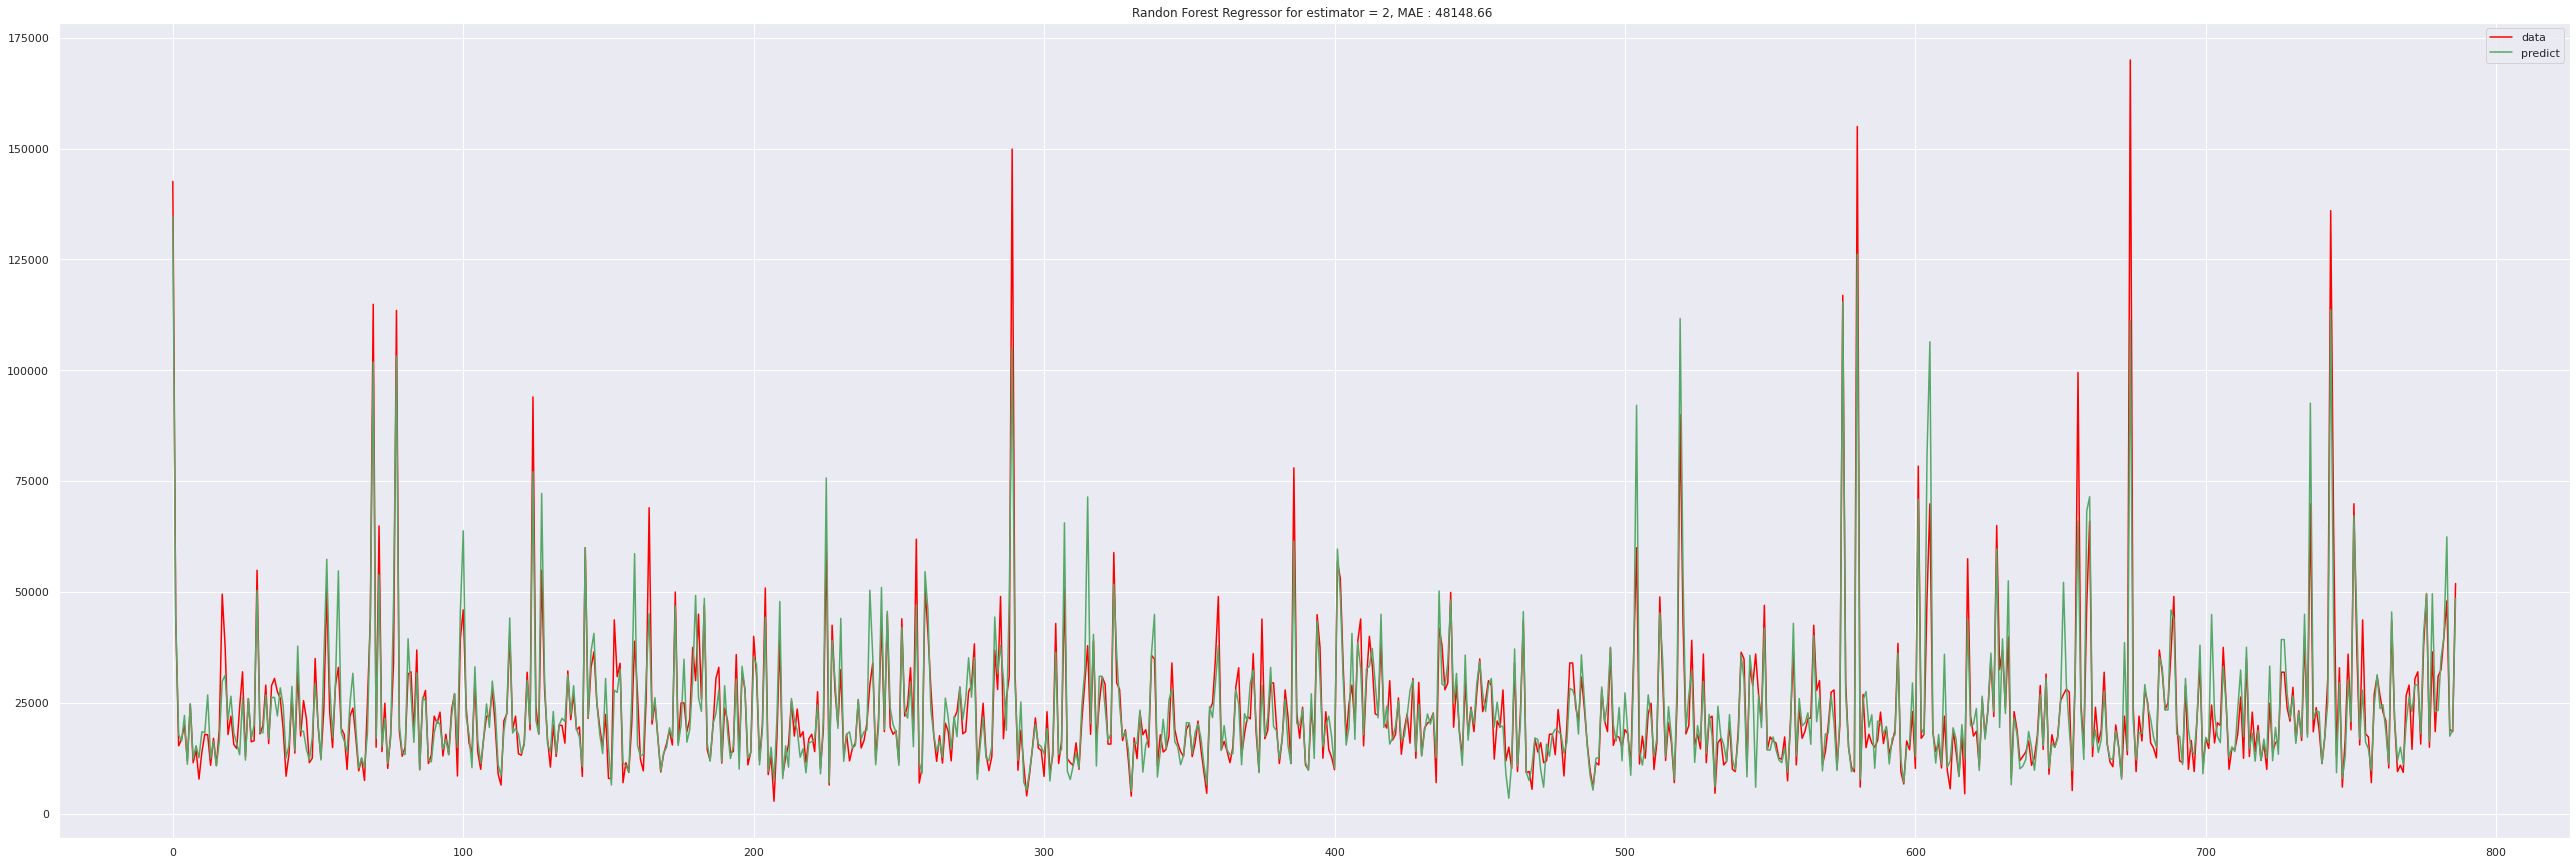

In [40]:
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx,y_test,c='red', label = 'data')
plt.plot(xx, y_predict, c='g', label = 'predict')
plt.axis('tight')
plt.legend()
plt.title('Randon Forest Regressor for estimator = 2, MAE : 48148.66 ')

plt.show()

In [41]:
dump(model, 'RandomForest.sav')

['RandomForest.sav']